In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
def scrape_linkedin_jobs(role, city, num_jobs=20):
    url = f"https://www.linkedin.com/jobs/search?keywords={role}&location={city}"
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    time.sleep(3)

    jobs = []
    job_listings = driver.find_elements(By.CLASS_NAME, "base-card")

    for job in job_listings[:num_jobs]:
        try:
            title = job.find_element(By.CLASS_NAME, "base-search-card__title").text
        except:
            title = ""
        try:
            company = job.find_element(By.CLASS_NAME, "base-search-card__subtitle").text
        except:
            company = ""
        try:
            location = job.find_element(By.CLASS_NAME, "job-search-card__location").text
        except:
            location = ""
        try:
            date = job.find_element(By.TAG_NAME, "time").text
        except:
            date = ""
        # Skills are not always shown on LinkedIn card — placeholder for demonstration
        skills = role  # treat searched role as proxy skill for now

        jobs.append([title, company, location, skills, date])

    driver.quit()
    
    df = pd.DataFrame(jobs, columns=["Job Title", "Company", "Location", "Skills", "Posted Date"])
    return df

In [15]:
df = scrape_linkedin_jobs("Data Scientist", "Berlin", num_jobs=30)

print("Sample data:")
print(df.head())

Sample data:
                                           Job Title          Company  \
0           (Junior) Machine Learning Engineer (all)         mediaire   
1                          Machine Learning Engineer       Reliant AI   
2  Senior Data Scientist - (Logistics, Optimization)    Delivery Hero   
3                           Data Scientist - Pricing  Lovehoney Group   
4                      Energy Data Scientist (m/w/d)     Fuchs & Eule   

                  Location          Skills  Posted Date  
0  Berlin, Berlin, Germany  Data Scientist  2 weeks ago  
1  Berlin, Berlin, Germany  Data Scientist  1 month ago  
2  Berlin, Berlin, Germany  Data Scientist   1 week ago  
3  Berlin, Berlin, Germany  Data Scientist   6 days ago  
4  Berlin, Berlin, Germany  Data Scientist   2 days ago  


In [4]:
df['Job Title'] = df['Job Title'].str.strip().str.replace(r'\s+', ' ', regex=True)
df['Company'] = df['Company'].str.strip()
df['Location'] = df['Location'].str.strip()
df['Skills'] = df['Skills'].fillna('').str.lower().str.replace(r'[^a-zA-Z, ]', '', regex=True)

df = df.drop_duplicates().dropna(subset=['Job Title', 'Company'])

In [5]:
all_skills = []
df['Skills'].apply(lambda x: all_skills.extend(x.split(',')))
skill_counts = Counter([s.strip() for s in all_skills if s.strip() != ''])
top_skills = pd.DataFrame(skill_counts.most_common(15), columns=['Skill', 'Count'])

print("\nTop Skills:")
print(top_skills)


Top Skills:
            Skill  Count
0  data scientist     16


C:\Users\akash\AppData\Local\Temp\ipykernel_3976\291349122.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=top_skills, palette='viridis')


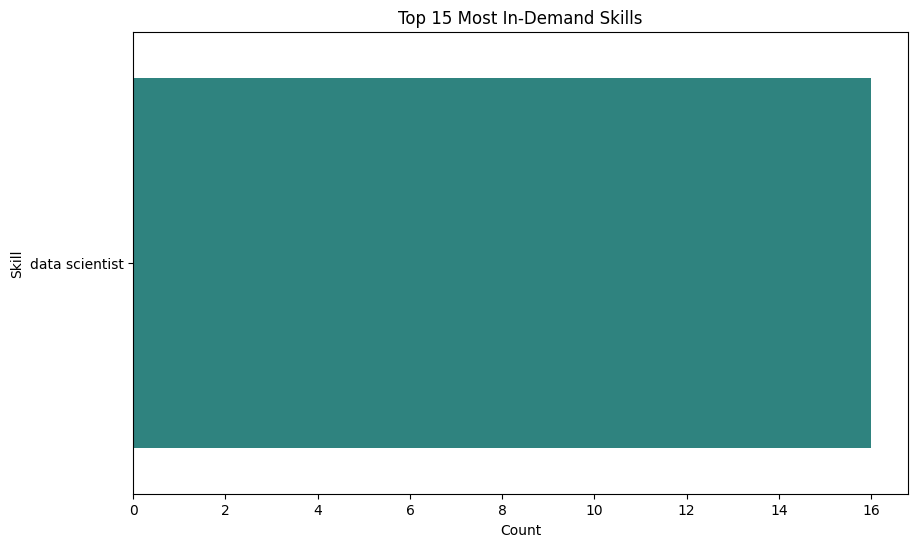

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Skill', data=top_skills, palette='viridis')
plt.title("Top 15 Most In-Demand Skills")
plt.show()

In [7]:
city_skill_counts = df.groupby('Location')['Skills'].apply(lambda x: ','.join(x)).reset_index()

city_skill_freq = {}
for _, row in city_skill_counts.iterrows():
    skills = [s.strip() for s in row['Skills'].split(',') if s.strip()]
    for s in skills:
        city_skill_freq.setdefault(row['Location'], Counter()).update([s])

for city, counts in city_skill_freq.items():
    print(f"\nTop skills in {city}:")
    print(counts.most_common(5))


Top skills in :
[('data scientist', 2)]

Top skills in Berlin, Berlin, Germany:
[('data scientist', 14)]


C:\Users\akash\AppData\Local\Temp\ipykernel_3976\2449481378.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Company', data=top_companies, palette='coolwarm')


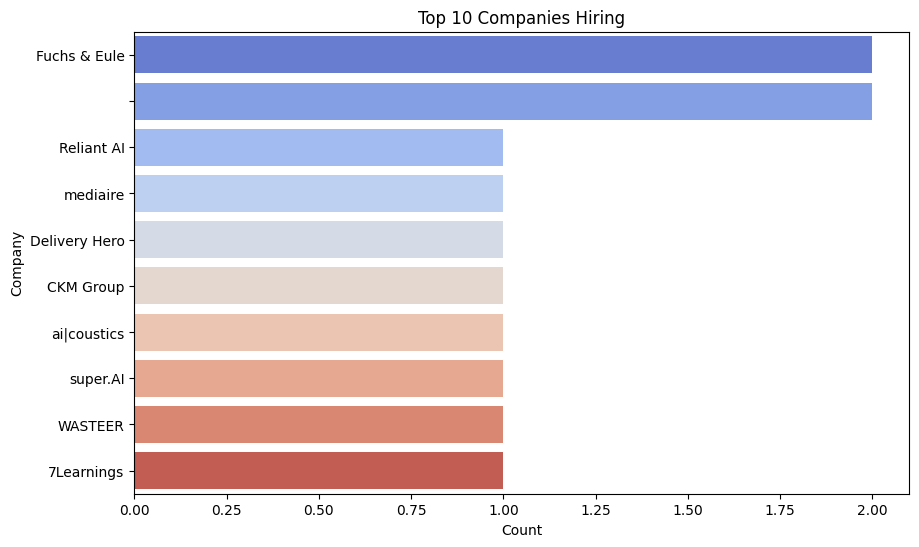

In [8]:
top_companies = df['Company'].value_counts().head(10).reset_index()
top_companies.columns = ['Company', 'Count']

plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Company', data=top_companies, palette='coolwarm')
plt.title("Top 10 Companies Hiring")
plt.show()

C:\Users\akash\AppData\Local\Temp\ipykernel_3976\2631497328.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Location', data=top_locations, palette='mako')


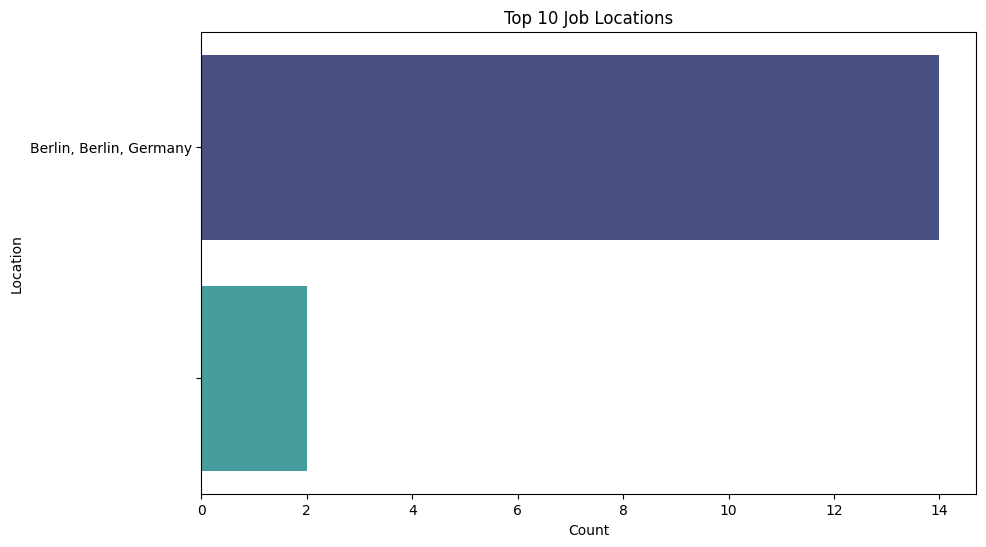

In [9]:
top_locations = df['Location'].value_counts().head(10).reset_index()
top_locations.columns = ['Location', 'Count']

plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Location', data=top_locations, palette='mako')
plt.title("Top 10 Job Locations")
plt.show()

In [10]:
df.to_csv("job_postings.csv", index=False)

In [11]:
print(df['Company'].value_counts().head(10))

Company
Fuchs & Eule     2
                 2
Reliant AI       1
mediaire         1
Delivery Hero    1
CKM Group        1
ai|coustics      1
super.AI         1
WASTEER          1
7Learnings       1
Name: count, dtype: int64


In [12]:
print(df['Posted Date'].value_counts())

Posted Date
                3
2 weeks ago     2
1 month ago     2
4 days ago      2
1 week ago      2
6 days ago      1
2 days ago      1
3 months ago    1
9 months ago    1
3 days ago      1
Name: count, dtype: int64


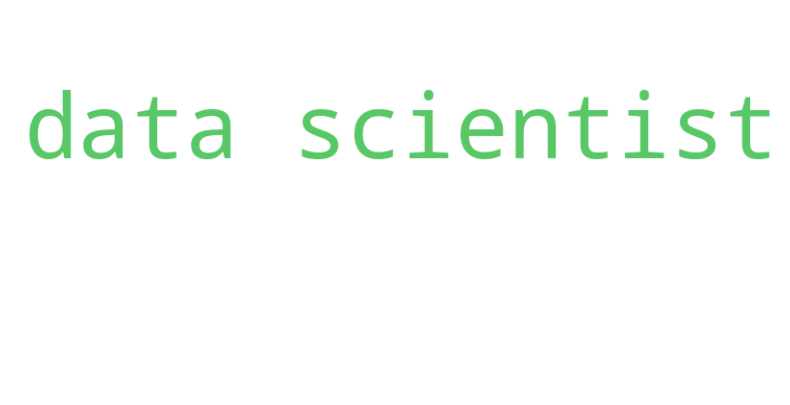

In [13]:
from wordcloud import WordCloud
text = " ".join(all_skills)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()